In [1]:
import mip
import itertools
import random
from scipy.spatial import distance_matrix
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class VRPInstance(object):
    def __init__(self, nodes=[], nodes_pos = {}, trucks = [],origin = {}, cost_matrix =  None ): # TODO add miga_and_bloqued
        """ create an empty instance
        """
        self.trucks = trucks
        self.origin = origin
        self.cost_matrix =  cost_matrix # this could be part of the edges attributes of self.graph

        # graph 
        G = nx.Graph() 
        G.add_nodes_from(nodes)
        for node_id,pos in nodes_pos.items():
            G.nodes[node_id]['pos'] = (pos[0],pos[1])

        self.graph = G

    @classmethod 
    def generate_random_xy_instance(cls, n_nodes = 15, n_trucks=2, starting_nodes='default'):
        """[summary]

        Args:
            n_nodes (int, optional): [description]. Defaults to 15.
            n_trucks (int, optional): [description]. Defaults to 2.
            starting_nodes (str, optional): [description]. Defaults to 'default'.

        Returns:
            [type]: [description]
        """        
        # set seed 
        random.seed(0)             
        nodes = list(range(n_nodes))  
        nodes_pos = {}
        nodes_pos_list  = []
        for node_id in nodes:
            x = random.uniform(0, 150)
            y = random.uniform(0, 150)
            nodes_pos[node_id] = (x,y) 
            nodes_pos_list.append([x,y])
            
        cost_matrix = distance_matrix(nodes_pos_list, nodes_pos_list)
        
        nodes = list(range(cost_matrix.shape[0]))
        trucks = list(range(n_trucks))
        if starting_nodes == 'default':
            origin = {}
            for k in trucks:
                origin[k]=k
        elif type(starting_nodes) == dict:
            origin = deepcopy(starting_nodes)
            
        return cls(nodes = nodes, 
                   nodes_pos = nodes_pos, 
                   trucks = trucks,
                   origin = origin,
                   cost_matrix=cost_matrix)
    @property
    def nodes(self):
        return list(self.graph.nodes)
    
    def cost(self, i,j):
        return self.cost_matrix[i][j]

    @classmethod
    def generate_random_distance_instance(cls, n_nodes, n_trucks):
        # TODO
        raise NotImplementedError('builder not yet implemented')
        #cost_matrix  = np.random.rand(45,45) # matriz tiempo o distancia
        #cost_matrix =  cost_matrix + cost_matrix.T  - 2*np.diag(cost_matrix.diagonal())
    
    def plot_instance(self):
        G = self.graph
        pos=nx.get_node_attributes(G,'pos')
        nx.draw(G, pos=pos, with_labels = True)
    
    def plot_solution(self, x, y, file_name='graph.png'):
        """ 
        plot the solution 

        Args:
            x ([dict]): dict with solution {x[(i,j,k)] : mip.Var, ... }
        """         
        
        G = deepcopy(self.graph)
        G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) 
        pos = nx.get_node_attributes(G,'pos')
        node_color = [key[1] for key in y.keys() if y[key].x==1]
        max_color = np.max(node_color) + 1
        labels = {nodo:nodo for nodo in self.nodes}
        origen = self.origin
        for k in origen.keys():
            labels[origen[k]] = str(labels[origen[k]])+'*'
        # save plot 
        f = plt.figure()
        nx.draw(G, pos=pos, labels=labels,
                node_color = node_color, cmap=plt.cm.spring,
                with_labels = True, ax=f.add_subplot(111))
        f.savefig(file_name, dpi = 250)

In [18]:
def find_optimal_solution(vrp_instance, objective_function = 'min_distance'):
    nodes = vrp_instance.nodes
    trucks = vrp_instance.trucks
    origin = vrp_instance.origin

    # model
    model = mip.Model(name =  'vrp')
    # ========================== #
    # ==== var declaration ===== #
    # ========================== #

    x = {}
    for i,j,k in itertools.product(nodes,nodes,trucks):
        # declarate path variables 
        if i != j : 
            x[(i,j,k)] = model.add_var(var_type = mip.BINARY , 
                                    name = f'path_{i}_{j}_{k}')

    y = {}    
    for i,k in itertools.product(nodes,trucks):
        # declarate path variables 
        y[(i,k)] = model.add_var(var_type = mip.CONTINUOUS , 
                                name = f'asignation_{i}_{k}')

    u = {} # path length variable 
    for i,k in itertools.product(nodes,trucks):
        u[(i,k)] = model.add_var(var_type = mip.INTEGER , 
                                name = f'order_{i}_{k}')

    z = {} # last node 
    for i,k in itertools.product(nodes,trucks):
        # declarate path variables 
        #if i != origin[k]:
        z[(i,k)] = model.add_var(var_type = mip.BINARY , 
                                    name = f'end_node_{i}_{k}')


    # ======================== #
    # ===== constraints ====== #
    # ======================== #
    # AUX.
#     for k in trucks:
#         model.add_constr(mip.xsum([x[(origin[k],i,k)] for i in nodes if i!=origin[k]])==1, name=f'aux_{k}')
    for i in nodes:
        model.add_constr(mip.xsum([x[(j,i,k)] for j,k in itertools.product(nodes,trucks) if j!=i])==1, name=f'fullfill2_{i}_{k}')
    
    
    # 0. end node codification  
    for k in trucks:
        model.add_constr(mip.xsum([z[(i,k)] for i in nodes if i!= origin[k]])==1, name=f'sos_{k}')
        #model.add_sos([(z[(i,k)],1) for i in nodes], sos_type=1, ) 
        #model.add_sos([(z[(i,k)],1) for i in nodes if i!= origin[k]], sos_type=1) 

    # 1. flow conservation
    for i,k in itertools.product(nodes,trucks):
        if i != origin[k]:
            model.add_constr(mip.xsum([x[(j,i,k)] for j in nodes if j!=i ]) == # lo que entra
                            mip.xsum([x[(i,j,k)] for j in nodes if j!=i ]) - z[(i,k)] , # lo que sale
                            name = f'flow_conservation_{i}_{k}' )
#         if i == origin[k]:
#             model.add_constr(mip.xsum([x[(i,j,k)] for j in nodes if j!=i ]) == 1, # lo que sale
#                             name = f'flow_conservation_{i}_{k}' )
            
        
    # 2. y codification 
    for i,k in itertools.product(nodes,trucks):
        model.add_constr(y[(i,k)] == mip.xsum([x[(i,j,k)] for j in nodes if j!=i]) , name=f'y[{i}{k}]_cod') 
        #model.add_constr(y[(i,k)] == mip.xsum([x[(j,i,k)] for j in nodes if j!=i]) , name=f'y[{i}{k}]_cod')  

    # 3. demand fulfillment
    for i in nodes:
        model.add_constr(mip.xsum([ y[(i,k)] for k in trucks]) == 1 , name=f'full[{i}{k}]_cod') 

    
    # 4. subtour elimination 
    graph_len = len(nodes)
    for k in trucks:
        for i,j in itertools.product(nodes,nodes):
            if i != j and (i != origin[k] and j!= origin[k]): # remove origin 
                model.add_constr(u[(i,k)] - u[(j,k)] + 1  <= graph_len*(1- x[(i,j,k)]) , name=f'subtour_constraint_{i}_{j}_{k}')
        
        model.add_constr(u[(origin[k],k)] == 1 , name=f'subtour_constraint_origin_{k}')
        
        for i in nodes:
            if i != origin[k] :
                model.add_constr(u[(i,k)] >=2  , name=f'subtour_constraint_lowerbound_{i}')
                model.add_constr(u[(i,k)] <= graph_len -1, name=f'subtour_constraint_upperbound_{i}')
                

    # ============================ #
    # ==== model declaration ===== #
    # ============================ #

    # objective function
    if objective_function == 'min_distance':
        model.objective = mip.xsum([x[key]*vrp_instance.cost(key[0],key[1]) for key in x.keys()])

    elif objective_function == 'lowest_pos':
        model.objective = mip.xsum([u[key] for key in u.keys()])
    
    if objective_function == 'min_dist_max_len':
        for key in u.keys():
            model.add_constr(u[key] <= int(graph_len/len(trucks) *1.15) +1  , name='max_len')
        model.objective = mip.xsum([x[key]*vrp_instance.cost(key[0],key[1]) for key in x.keys()])
    
    model.sens = mip.MINIMIZE

    # model tunning
    # cuts
    # -1  automatic, 0 disables completely, 
    # 1 (default) generates cutting planes in a moderate way,
    # 2 generates cutting planes aggressively  
    # 3 generates even more cutting planes
    model.cuts = 2 
    model.max_mip_gap = 0.005 # 0.5%
    model.max_seconds = 15*60 
    model.optimize()

    """
    for key,var in x.items():
        print('x',key, var.x)

    for key,var in y.items():
        print('y',key, var.x)
    """
    for k in trucks:
        print('total nodes served by {0} = {1}'.format(k, sum([y[(i,k)].x for i in nodes ])))

    for k in trucks:
        print('node_list = {}'.format([ i for i in nodes if y[(i,k)].x == 1]))
        
    return x, y, u, z

In [23]:
# generate a instance 
vrp_instance = VRPInstance.generate_random_xy_instance(n_nodes = 10, 
                                                       n_trucks=4, 
                                                       starting_nodes='default')

total nodes served by 0 = 5.0
total nodes served by 1 = 2.0
total nodes served by 2 = 1.0
total nodes served by 3 = 2.0
node_list = [2, 4, 6, 8, 9]
node_list = [3, 7]
node_list = [1]
node_list = [0, 5]
CPU times: user 2.18 s, sys: 171 ms, total: 2.35 s
Wall time: 1.79 s


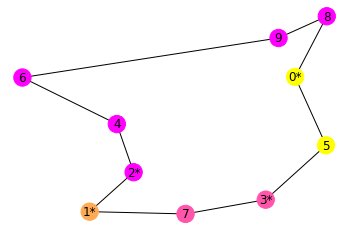

In [24]:
%%time

x, y, u, z = find_optimal_solution(vrp_instance, objective_function='min_distance')
vrp_instance.plot_solution(x, y, file_name = 'min_distance.png')

In [17]:
[k for k in x.keys() if x[k].x==1]

[(0, 6, 2),
 (1, 7, 0),
 (2, 1, 1),
 (3, 5, 0),
 (4, 2, 2),
 (5, 0, 0),
 (6, 4, 2),
 (7, 3, 0),
 (8, 9, 0),
 (9, 8, 0)]

In [10]:
[k for k in z.keys() if z[k].x==1]

[(0, 2), (1, 0), (2, 1)]

In [11]:
[k for k in y.keys() if y[k].x>0]

[(0, 2),
 (1, 0),
 (2, 1),
 (3, 0),
 (4, 2),
 (5, 0),
 (6, 2),
 (7, 0),
 (8, 2),
 (9, 2)]

In [ ]:
vrp_instance.origin

In [ ]:
z.keys()

In [ ]:
%%time

x_lp, y_lp = find_optimal_solution(vrp_instance, objective_function='lowest_pos')
vrp_instance.plot_solution(x_lp, y_lp, file_name = 'lowest_pos.png')

In [ ]:
%%time

x_lp2, y_lp2 = find_optimal_solution(vrp_instance, objective_function='min_dist_max_len')
vrp_instance.plot_solution(x_lp2, y_lp2, file_name = 'min_dist_max_len.png')

In [ ]:
cost_matrix  = np.random.rand(10,10) # matriz tiempo o distancia
cost_matrix =  cost_matrix + cost_matrix.T  - 2*np.diag(cost_matrix.diagonal())

nodes = list(range(cost_matrix.shape[0]))
trucks = list(range(3))

origin = {}
for k in trucks:
    origin[k]=k

plt.imshow(cost_matrix, cmap=plt.cm.Blues,)
plt.title('matriz de costo')

In [ ]:
cost_matrix[:4,4:] = 100
cost_matrix[4:7,:4] = 100
cost_matrix[4:7,7:] = 100
cost_matrix[7:,:7] = 100


plt.imshow(cost_matrix, cmap=plt.cm.Blues,)


In [ ]:
k+=1
model = mip.Model(name = f'vrp_{k}')

# ========================== #
# ==== var declaration ===== #
# ========================== #
x = {}

for i,j,k in itertools.product(nodes,nodes,trucks):
    # declarate path variables 
    if i != j : 
        x[(i,j,k)] = model.add_var(var_type = mip.BINARY , 
                                   name = f'path_{i}_{j}_{k}')
y = {}    
for i,k in itertools.product(nodes,trucks):
    # declarate path variables 
    y[(i,k)] = model.add_var(var_type = mip.CONTINUOUS , 
                             name = f'asignation_{i}_{k}')

u = {}
for i,k in itertools.product(nodes,trucks):
    u[(i,k)] = model.add_var(var_type = mip.INTEGER , 
                             name = f'order_{i}_{k}')

In [ ]:
# ======================== #
# ===== constraints ====== #
# ======================== #

# 1. flow conservation
for i,k in itertools.product(nodes,trucks):
    if i != origin[k]:
        model.add_constr(mip.xsum([x[(j,i,k)] for j in nodes if j!=i ]) == # lo que entra
                         mip.xsum([x[(i,j,k)] for j in nodes if j!=i ]) , # lo que sale
                         name = f'flow_conservation_{i}_{k}' ) 

# 2. y codification 
for i,k in itertools.product(nodes,trucks):
    model.add_constr(y[(i,k)] == mip.xsum([x[(j,i,k)] for j in nodes if j!=i]) , name=f'y[{i}{k}]_cod') 

# 3. demand fulfillment
for i in nodes:
    model.add_constr(mip.xsum([ y[(i,k)] for k in trucks]) == 1 , name=f'y[{i}{k}]_cod') 

# 4. subtour elimination 
graph_len = len(nodes)
for k in trucks:
    for i,j in itertools.product(nodes,nodes):
        if i != j and (i != origin[k] and j!= origin[k]): # remove origin (?)
            model.add_constr(u[(i,k)] - u[(j,k)] + 1  <= graph_len*(1- x[(i,j,k)]) , name=f'subtour_constraint_{i}_{j}_{k}')
    
    model.add_constr(u[(origin[k],k)] == 1 , name=f'subtour_constraint_origin_{k}')
    
    for i in nodes:
        if i != origin[k] :
            model.add_constr(u[(i,k)] >=2  , name=f'subtour_constraint_lowerbound_{i}')
            model.add_constr(u[(i,k)] <= graph_len , name=f'subtour_constraint_upperbound_{i}')

In [ ]:
# ============================ #
# ==== model declaration ===== #
# ============================ #

# objective function
model.objective = mip.xsum([x[key]*cost_matrix[key[0]][key[1]] for key in x.keys()])

model.sens = mip.MINIMIZE
model.optimize()

In [ ]:
# ============================ #
# ==== printing results  ===== #
# ============================ #
for key,var in x.items():
    if var.x == 1.0:
        print('x',key, var.x)

for key,var in y.items():
    if var.x == 1.0:
        print('y',key, var.x)

for k in trucks:
    print('total nodes served by {0} = {1}'.format(k, sum([y[(i,k)].x for i in nodes ])))

for k in trucks:
    print('node_list = {}'.format([ i for i in nodes if y[(i,k)].x == 1]))

# ====================== #
# ==== viz results ===== #
# ====================== #

import networkx as nx
G = nx.Graph()

G.add_nodes_from(nodes)
G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) #{'weight': 3.1415}
colors = [key[2]+2 for key in x.keys() if x[key].x == 1]
nx.draw(G, node_color=colors, with_labels = True, cmap=plt.cm.Blues)

In [ ]:
# ============================ #
# ==== printing results  ===== #
# ============================ #
for key,var in x.items():
    if var.x == 1.0:
        print('x',key, var.x)

for key,var in y.items():
    if var.x == 1.0:
        print('y',key, var.x)

for k in trucks:
    print('total nodes served by {0} = {1}'.format(k, sum([y[(i,k)].x for i in nodes ])))

for k in trucks:
    print('node_list = {}'.format([ i for i in nodes if y[(i,k)].x == 1]))

# ====================== #
# ==== viz results ===== #
# ====================== #

import networkx as nx
G = nx.Graph()

G.add_nodes_from(nodes)
G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) #{'weight': 3.1415}
colors = [key[2]+2 for key in x.keys() if x[key].x == 1]
nx.draw(G, node_color=colors, with_labels = True,)# cmap=plt.cm.Blues)

In [ ]:
# ============================ #
# ==== printing results  ===== #
# ============================ #
# for key,var in x.items():
#     print('x',key, var.x)

# for key,var in y.items():
#     print('y',key, var.x)

# for k in trucks:
#     print('total nodes served by {0} = {1}'.format(k, sum([y[(i,k)].x for i in nodes ])))

# for k in trucks:
#     print('node_list = {}'.format([ i for i in nodes if y[(i,k)].x == 1]))

# ====================== #
# ==== viz results ===== #
# ====================== #

import networkx as nx
G = nx.Graph()

G.add_nodes_from(nodes)
G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) #{'weight': 3.1415}

nx.draw(G, with_labels = True)

In [ ]:
# ====================== #
# ==== viz results ===== #
# ====================== #

import networkx as nx
G = nx.Graph()

G.add_nodes_from(nodes)
G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) #{'weight': 3.1415}

nx.draw(G, with_labels = True)

In [ ]:
# ====================== #
# ==== viz results ===== #
# ====================== #

import networkx as nx
G = nx.Graph()

G.add_nodes_from(nodes)
G.add_edges_from([(key[0], key[1]) for key in x.keys() if x[key].x == 1]) #{'weight': 3.1415}

nx.draw(G, with_labels = True)